In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import time

from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import RandomizedSearchCV,train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import log_loss,roc_auc_score, confusion_matrix,ConfusionMatrixDisplay, roc_curve, classification_report

In [2]:
data=pd.read_csv(r"C:\Users\Kola Karthikeya\Desktop\Customer Churn Prediction\customer churn.csv")
df=pd.DataFrame(data.iloc[:,1:])

y = df['Churn']
X = df.drop(["Churn"],axis = 1)

In [3]:
cont_cols = X.select_dtypes(exclude = "object").columns
cat_cols = X.select_dtypes(include = "object").columns

In [4]:
cont_cols

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [5]:
cat_cols

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [6]:
X_encoded = pd.get_dummies(df[cat_cols], drop_first=True)

chi_scores = chi2 (X_encoded, y)
chi2_series = pd.Series(chi_scores[0], index=X_encoded.columns).sort_values(ascending=False)
chi2_series

Contract_Two year                        488.578090
PaymentMethod_Electronic check           426.422767
InternetService_Fiber optic              374.476216
StreamingMovies_No internet service      286.520193
DeviceProtection_No internet service     286.520193
StreamingTV_No internet service          286.520193
TechSupport_No internet service          286.520193
InternetService_No                       286.520193
OnlineSecurity_No internet service       286.520193
OnlineBackup_No internet service         286.520193
Contract_One year                        176.123171
OnlineSecurity_Yes                       147.295858
TechSupport_Yes                          135.559783
Dependents_Yes                           133.036443
PaperlessBilling_Yes                     105.680863
PaymentMethod_Credit card (automatic)     99.582057
Partner_Yes                               82.412083
PaymentMethod_Mailed check                45.651590
OnlineBackup_Yes                          31.217694
DeviceProtec

In [7]:
chi2_series.index[:10]

Index(['Contract_Two year', 'PaymentMethod_Electronic check',
       'InternetService_Fiber optic', 'StreamingMovies_No internet service',
       'DeviceProtection_No internet service',
       'StreamingTV_No internet service', 'TechSupport_No internet service',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service'],
      dtype='object')

In [8]:
cat_cols[cat_cols != "Contract"]

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod'],
      dtype='object')

In [9]:
cont_pl = Pipeline(steps = [('Imputation',SimpleImputer(strategy="median")),
                           ('Scaling',StandardScaler()),
                           ('PowerTransformation',PowerTransformer())])

cat_nominal_pl = Pipeline(steps = [('Imputation',SimpleImputer(strategy="most_frequent")),
                          ('Onehot encoding',OneHotEncoder(sparse_output=False,drop='first'))])

cat_ordinal_pl = Pipeline(steps = [('Imputation',SimpleImputer(strategy = "most_frequent")),
                                  ('Ordinal encoding',OrdinalEncoder())])

ct = ColumnTransformer(transformers= [('Continuous Cols',cont_pl,cont_cols),
                                     ('Cat Nominal Cols',cat_nominal_pl,cat_cols[cat_cols != "Contract"]),
                                     ('Cat Ordinal Cols',cat_ordinal_pl,['Contract'])])

final_pl = Pipeline([('Final',ct)])

final_pl

Pipeline(steps=[('Final',
                 ColumnTransformer(transformers=[('Continuous Cols',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaling',
                                                                   StandardScaler()),
                                                                  ('PowerTransformation',
                                                                   PowerTransformer())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('Cat Nominal Cols',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleI...
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod'],
      dtype='object')),
                                                 ('Cat Ordinal Cols',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Ordinal '
                                                                   'encoding',
                                                                   OrdinalEncoder())]),
                                                  ['Contract'])]))])

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=10,stratify=y)

X_train_df = pd.DataFrame(final_pl.fit_transform(X_train),columns=final_pl.get_feature_names_out())
X_test_df = pd.DataFrame(final_pl.transform(X_test),columns = final_pl.get_feature_names_out())

In [14]:
def random_search(model,param_grid, score,clf_name):
    random_search = RandomizedSearchCV(model, param_grid, scoring=score, cv=5)
    
    start_time = time.time()
    random_search.fit(X_train_df, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    best_model = random_search.best_estimator_

    start_time = time.time()
    y_pred = best_model.predict(X_test_df)
    end_time = time.time()
    testing_time = end_time - start_time

    clf_report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(clf_report).transpose()

    proba_predict=best_model.predict_proba(X_test_df)
    fpr,tpr,__=roc_curve(y_test,proba_predict[:,1])
    
    print("--"*100)
    print("Classifier", clf_name)
    print("Best parameters found", random_search.best_params_)
    print("Best cross-validation score", random_search.best_score_)
    print("Training time", training_time)
    print("Testing time", testing_time)
    print("Roc-Auc score", roc_auc_score(y_test,y_pred))
    print("Log-loss", log_loss(y_test,proba_predict))
    print("Classification Report", clf_report)
    print("Receiver Operating Characteristic (ROC) Curve:")
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {clf_name}")
    plt.legend(loc="best")
    plt.show()
    print("Confusion Matrix:")
    cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
    cm.plot()
    plt.show()

In [15]:
def Select_model():

    print("Select the model :","KNeighborsClassifier, GaussianNB, LogisticRegression, SVC, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier")

    clf_name=input("Enter the Model name:")
    results = []
    if clf_name == "KNeighborsClassifier":
        knn_clf = KNeighborsClassifier()
        param_grid = {
            'n_neighbors': [i for i in range(1, 20, 2)],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
        random_search(knn_clf, param_grid, "roc_auc",clf_name)

    elif clf_name == "GaussianNB":
        GNB_clf = GaussianNB()
        param_grid = {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        }
        random_search(GNB_clf, param_grid, "roc_auc",clf_name)

    elif clf_name == "LogisticRegression":
        LR_clf = LogisticRegression(max_iter=10000)
        param_grid = [
            {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
            {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
            {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': np.linspace(0, 1, 5)},
            {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none'], 'solver': ['newton-cg', 'lbfgs', 'sag']}
        ]
        random_search(LR_clf, param_grid, "accuracy",clf_name)

    elif clf_name == "SVC":
        SVC_clf = SVC(probability=True)
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale', 'auto']
        }
        random_search(SVC_clf, param_grid, 'f1',clf_name)

    elif clf_name == "DecisionTreeClassifier":
        DT_clf = DecisionTreeClassifier()
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
        random_search(DT_clf, param_grid, 'accuracy',clf_name)

    elif clf_name == "RandomForestClassifier":
        RFC_clf = RandomForestClassifier()
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
        random_search(RFC_clf, param_grid, 'accuracy',clf_name)

    elif clf_name == "GradientBoostingClassifier":
        GBC_clf = GradientBoostingClassifier()
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'min_samples_split': [2, 5, 10]
        }
        random_search(GBC_clf, param_grid, 'accuracy',clf_name)

    else:
        print("Model is not recognized.")


Select the model : KNeighborsClassifier, GaussianNB, LogisticRegression, SVC, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier
Enter the Model name:KNeighborsClassifier
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Classifier KNeighborsClassifier
Best parameters found {'weights': 'uniform', 'n_neighbors': 17, 'metric': 'minkowski'}
Best cross-validation score 0.8300199015303373
Training time 6.272350549697876
Testing time 0.5907504558563232
Roc-Auc score 0.6933206747784754
Log-loss 0.6054375085015908
Classification Report {'0': {'precision': 0.8341143392689785, 'recall': 0.8599033816425121, 'f1-score': 0.8468125594671742, 'support': 1035}, '1': {'precision': 0.5760233918128655, 'recall': 0.5267379679144385, 'f1-score': 0.5502793296089385, 'support': 374}, 'accuracy': 0.7714691270404542, 'macro avg': {'precis

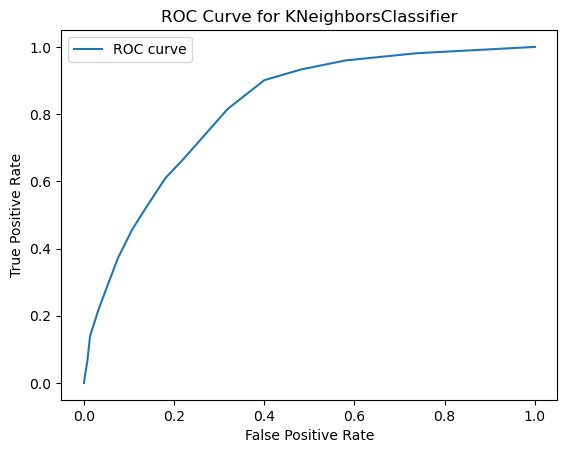

Confusion Matrix:


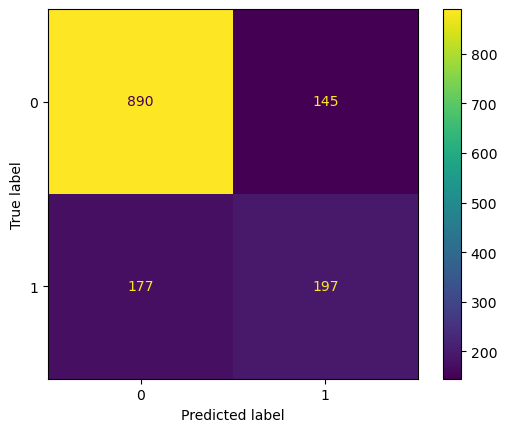

In [16]:
Select_model()

Select the model : KNeighborsClassifier, GaussianNB, LogisticRegression, SVC, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier
Enter the Model name:GaussianNB
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Classifier GaussianNB
Best parameters found {'var_smoothing': 1e-09}
Best cross-validation score 0.8207652464385868
Training time 0.2535543441772461
Testing time 0.006488323211669922
Roc-Auc score 0.7333346250226045
Log-loss 2.4390205540589216
Classification Report {'0': {'precision': 0.9333333333333333, 'recall': 0.5816425120772947, 'f1-score': 0.7166666666666667, 'support': 1035}, '1': {'precision': 0.43324607329842935, 'recall': 0.8850267379679144, 'f1-score': 0.5817223198594025, 'support': 374}, 'accuracy': 0.6621717530163236, 'macro avg': {'precision': 0.6832897033158813, 'recall': 0.7333346250226045, 

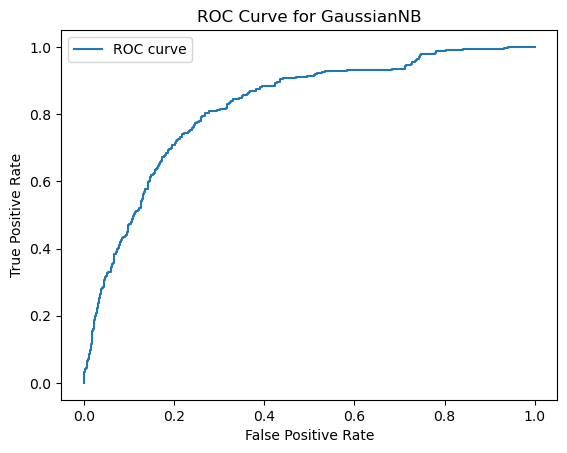

Confusion Matrix:


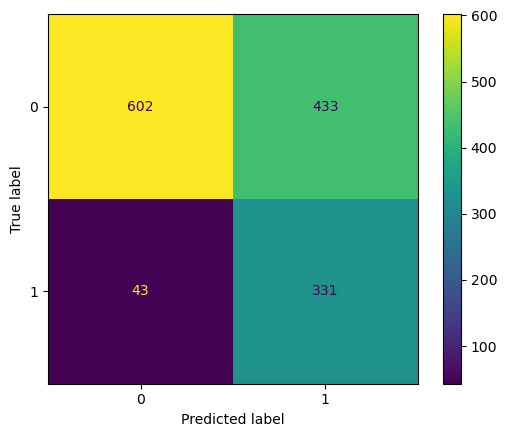

In [17]:
Select_model()

Select the model : KNeighborsClassifier, GaussianNB, LogisticRegression, SVC, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier
Enter the Model name:LogisticRegression
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Classifier LogisticRegression
Best parameters found {'solver': 'sag', 'penalty': 'l2', 'C': 0.1}
Best cross-validation score 0.8093697251856182
Training time 6.657342910766602
Testing time 0.001996755599975586
Roc-Auc score 0.7040274871476918
Log-loss 0.42258497023273706
Classification Report {'0': {'precision': 0.8357400722021661, 'recall': 0.8946859903381642, 'f1-score': 0.8642090527298181, 'support': 1035}, '1': {'precision': 0.6378737541528239, 'recall': 0.5133689839572193, 'f1-score': 0.568888888888889, 'support': 374}, 'accuracy': 0.7934705464868701, 'macro avg': {'precision': 0.73680691317749

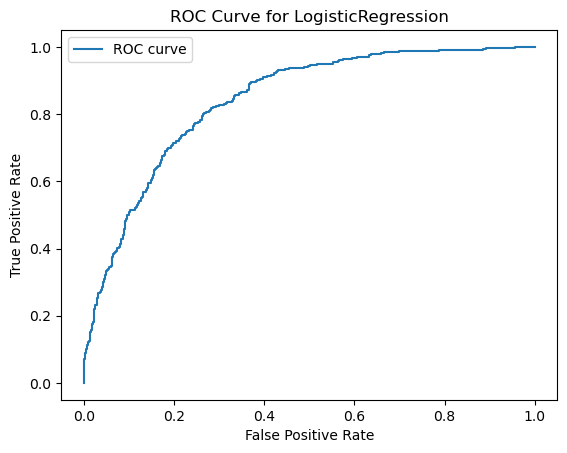

Confusion Matrix:


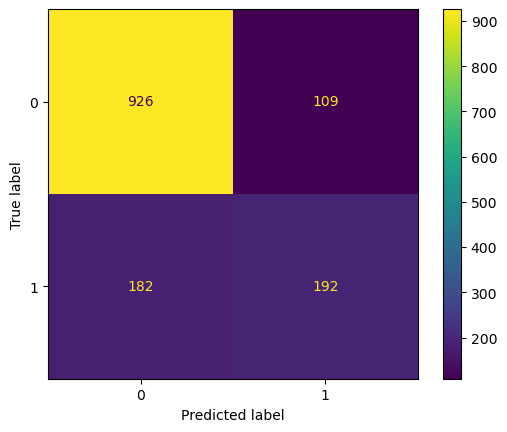

In [18]:
Select_model()

Select the model : KNeighborsClassifier, GaussianNB, LogisticRegression, SVC, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier
Enter the Model name:SVC
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Classifier SVC
Best parameters found {'kernel': 'poly', 'gamma': 'scale', 'C': 10}
Best cross-validation score 0.5744880468734453
Training time 248.96939325332642
Testing time 0.10775423049926758
Roc-Auc score 0.6889844738949598
Log-loss 0.48339554625535297
Classification Report {'0': {'precision': 0.8283649503161699, 'recall': 0.8859903381642512, 'f1-score': 0.8562091503267973, 'support': 1035}, '1': {'precision': 0.609271523178808, 'recall': 0.4919786096256685, 'f1-score': 0.5443786982248521, 'support': 374}, 'accuracy': 0.7814052519517388, 'macro avg': {'precision': 0.7188182367474889, 'recall': 0.6889844738949

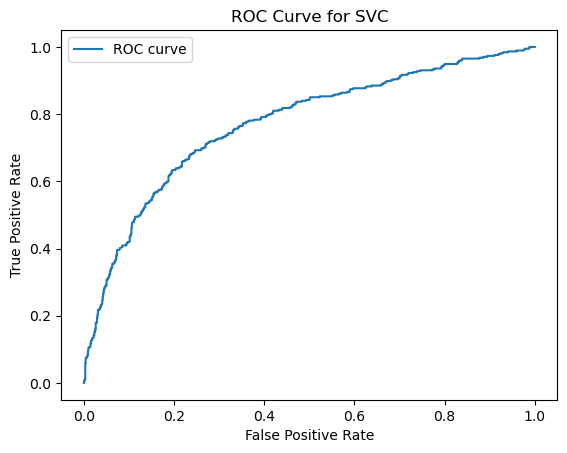

Confusion Matrix:


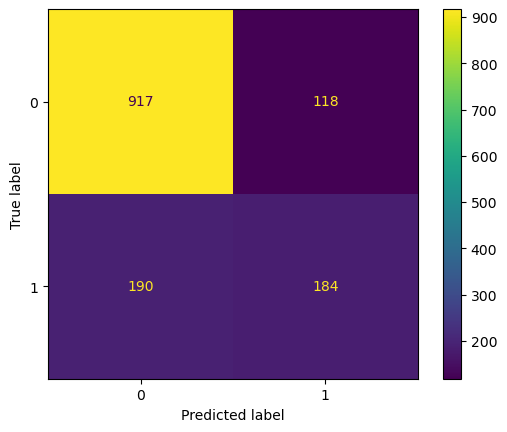

In [19]:
Select_model()

Select the model : KNeighborsClassifier, GaussianNB, LogisticRegression, SVC, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier
Enter the Model name:DecisionTreeClassifier
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Classifier DecisionTreeClassifier
Best parameters found {'splitter': 'random', 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'entropy'}
Best cross-validation score 0.783277725330614
Training time 1.0561861991882324
Testing time 0.0019953250885009766
Roc-Auc score 0.6878723294324317
Log-loss 1.447354441387027
Classification Report {'0': {'precision': 0.8270609318996416, 'recall': 0.8917874396135266, 'f1-score': 0.8582054858205486, 'support': 1035}, '1': {'precision': 0.6177474402730375, 'recall': 0.4839572192513369, 'f1-score': 0.5427286356821589, 'support': 374}, 

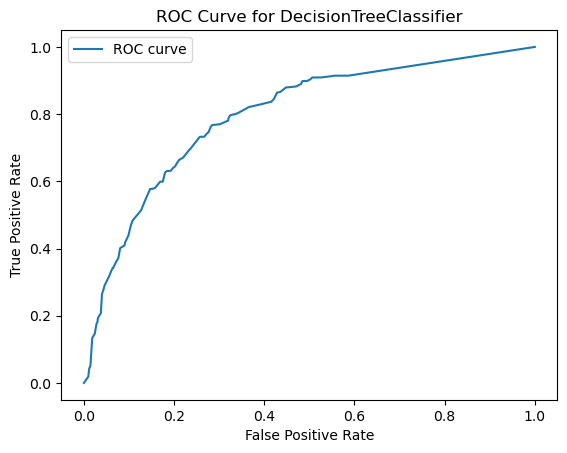

Confusion Matrix:


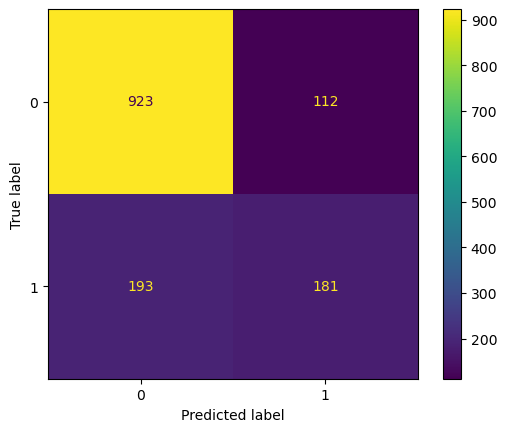

In [20]:
Select_model()

Select the model : KNeighborsClassifier, GaussianNB, LogisticRegression, SVC, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier
Enter the Model name:RandomForestClassifier
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Classifier RandomForestClassifier
Best parameters found {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Best cross-validation score 0.8088378111303213
Training time 45.696677446365356
Testing time 0.029746055603027344
Roc-Auc score 0.6884342142654163
Log-loss 0.42420438416186956
Classification Report {'0': {'precision': 0.8257042253521126, 'recall': 0.9062801932367149, 'f1-score': 0.8641179180101335, 'support': 1035}, '1': {'precision': 0.6446886446886447, 'recall': 0.47058823529411764, 'f1-score': 0.5440494590417

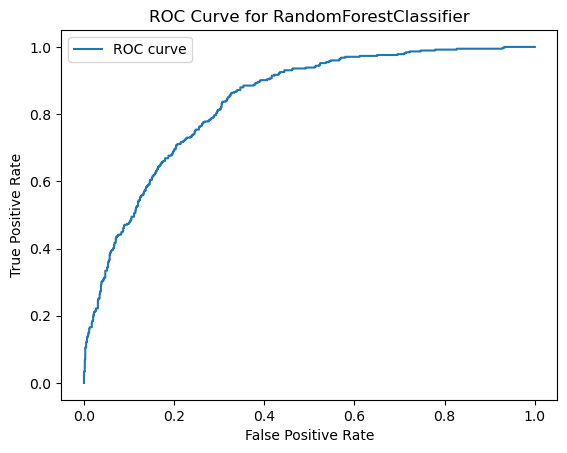

Confusion Matrix:


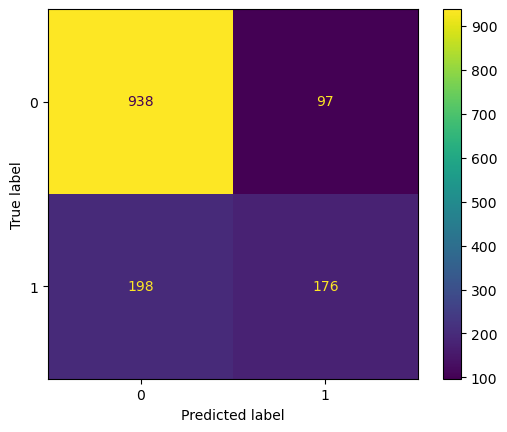

In [21]:
Select_model()

Select the model : KNeighborsClassifier, GaussianNB, LogisticRegression, SVC, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier
Enter the Model name:GradientBoostingClassifier
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Classifier GradientBoostingClassifier
Best parameters found {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 5, 'learning_rate': 0.01}
Best cross-validation score 0.8058204794003476
Training time 144.458238363266
Testing time 0.01632523536682129
Roc-Auc score 0.68490661086569
Log-loss 0.42031854591392664
Classification Report {'0': {'precision': 0.8236842105263158, 'recall': 0.9072463768115943, 'f1-score': 0.863448275862069, 'support': 1035}, '1': {'precision': 0.6431226765799256, 'recall': 0.4625668449197861, 'f1-score': 0.5381026438569206, 'support': 374}, 'accu

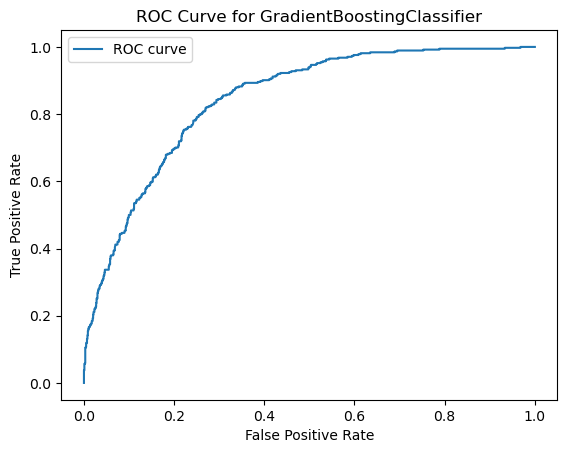

Confusion Matrix:


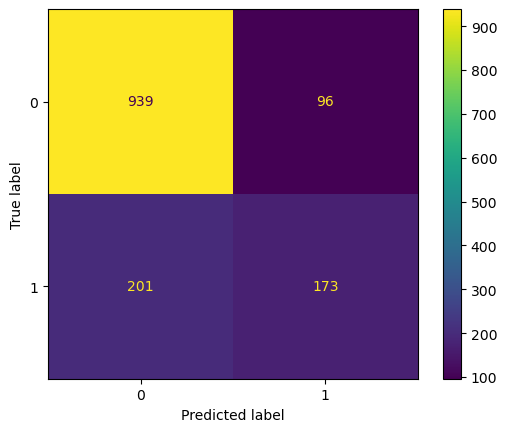

In [22]:
Select_model()